# Examine simulation approach

**Question:** Can we separate between generic and specific genes by adding gaussian noise to simulate experiments? Does VAE approach recapitulate generic genes better than gaussian noise approach?

To answer this question we will compare how well SOPHIE (VAE approach) can recapitulate manually curated generic genes (Crow et al.) compared to generic genes generated using noise approach

In this notebook we will:
1. Generate the noise simulated experiments
2. Compare generic genes against Crow et al. generic genes
3. Compare SOPHIE vs Crow et al. results against noise vs Crow et al. results. The results for SOPHIE vs Crow et al. can be found [here](http://localhost:8888/notebooks/human_general_analysis/2_identify_generic_genes_pathways.ipynb).

In [1]:
%load_ext autoreload
%load_ext rpy2.ipython
%autoreload 2

import os
import sys
import pandas as pd
import numpy as np
import pickle
import scipy.stats as ss

from rpy2.robjects import pandas2ri
from ponyo import utils
from generic_expression_patterns_modules import process, stats, ranking

pandas2ri.activate()

np.random.seed(123)

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
Using TensorFlow backend.


In [2]:
# Read in config variables
base_dir = os.path.abspath(os.path.join(os.getcwd(), "../"))

config_filename = os.path.abspath(
    os.path.join(base_dir, "configs", "config_human_general.tsv")
)

params = utils.read_config(config_filename)

In [3]:
# Load params
local_dir = params["local_dir"]
project_id = params["project_id"]
dataset_name = params["dataset_name"]
mapped_template_filename = params["mapped_template_filename"]
processed_template_filename = params["processed_template_filename"]
num_runs = params["num_simulated"]
col_to_rank_genes = params["rank_genes_by"]
count_threshold = params["count_threshold"]
logFC_name = params["DE_logFC_name"]
pvalue_name = params["DE_pvalue_name"]

# Set mean and variance for noise distribution
mu = 0
sigma = 2

# Load metadata file with grouping assignments for samples
sample_id_metadata_filename = os.path.join(
    base_dir, dataset_name, "data", "metadata", f"{project_id}_process_samples.tsv"
)

# Load metadata file with grouping assignments for samples
metadata_filename = os.path.join(
    base_dir, dataset_name, "data", "metadata", f"{project_id}_groups.tsv"
)

# Percentile threshold to identify generic genes
percentile_threshold = 80.0

In [4]:
# Output files
gene_summary_filename = os.path.join(
    base_dir, dataset_name, f"generic_gene_summary_{project_id}_noise_model.tsv"
)

## Simulate data using noise approach

1. Start with template experiment
2. Add gaussian noise vector to each sample
3. Process simulated data to remove any unnecessary samples

In [5]:
# Create subdirectory: "<local_dir>/pseudo_experiment_noise/"
os.makedirs(os.path.join(local_dir, "pseudo_experiment_noise"), exist_ok=True)

In [6]:
mapped_template = pd.read_csv(mapped_template_filename, sep="\t", index_col=0, header=0)

In [7]:
# Simulate data by adding noise
for i in range(num_runs):
    simulated_data_filename = os.path.join(
        local_dir,
        "pseudo_experiment_noise",
        f"selected_simulated_data_{project_id}_{i}.txt",
    )

    noise = np.random.normal(mu, sigma, mapped_template.shape)

    simulated_data = mapped_template + noise

    # Set any negative counts to 0
    simulated_data[simulated_data < 0] = 0

    simulated_data.to_csv(simulated_data_filename, sep="\t")

In [24]:
simulated_data_filename_0 = os.path.join(
    local_dir,
    "pseudo_experiment_noise",
    f"selected_simulated_data_{project_id}_0_processed.txt",
)

simulated_0 = pd.read_csv(simulated_data_filename_0, sep="\t", index_col=0, header=0)

simulated_0.head()

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A4GALT,A4GNT,AAAS,AACS,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
SRR493937,241,397,6,144073,2087,10,941,6,943,750,...,216,159,204,570,1616,7,766,12759,5056,771
SRR493938,227,385,8,142803,2062,7,968,6,978,772,...,216,172,217,578,1652,9,806,12923,5060,785
SRR493939,307,396,11,77650,1063,4,319,0,1631,1520,...,346,372,200,387,1315,28,839,4340,3305,741
SRR493940,304,347,13,77741,1126,13,323,0,1637,1479,...,316,319,155,451,1326,34,793,4401,3307,715
SRR493941,204,328,0,235642,2435,6,945,15,1519,1026,...,194,69,235,532,2006,8,1332,14318,4776,938


In [25]:
simulated_data_filename_20 = os.path.join(
    local_dir,
    "pseudo_experiment_noise",
    f"selected_simulated_data_{project_id}_20_processed.txt",
)

simulated_20 = pd.read_csv(simulated_data_filename_20, sep="\t", index_col=0, header=0)

simulated_20.head()

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A4GALT,A4GNT,AAAS,AACS,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
SRR493937,243,396,7,144078,2084,7,944,10,941,752,...,212,162,203,570,1614,10,765,12754,5060,771
SRR493938,232,385,6,142810,2062,8,963,3,977,778,...,216,171,214,576,1655,7,804,12924,5060,781
SRR493939,308,398,12,77652,1064,8,324,4,1634,1516,...,344,372,196,384,1317,29,844,4342,3304,743
SRR493940,301,351,15,77738,1124,11,321,0,1636,1480,...,319,315,152,447,1323,37,796,4401,3310,711
SRR493941,201,328,0,235649,2439,5,946,18,1522,1025,...,194,69,236,531,2008,8,1330,14319,4774,934


## Process template and simulated experiments

* Remove samples not required for comparison
* Make sure ordering of samples matches metadata for proper comparison
* Make sure values are cast as integers for using DESeq
* Filter lowly expressed genes for using DESeq

In [10]:
if not os.path.exists(sample_id_metadata_filename):
    sample_id_metadata_filename = None

stats.process_samples_for_DESeq(
    mapped_template_filename,
    metadata_filename,
    processed_template_filename,
    count_threshold,
    sample_id_metadata_filename,
)

for i in range(num_runs):
    simulated_filename = os.path.join(
        local_dir,
        "pseudo_experiment_noise",
        f"selected_simulated_data_{project_id}_{i}.txt",
    )
    out_simulated_filename = os.path.join(
        local_dir,
        "pseudo_experiment_noise",
        f"selected_simulated_data_{project_id}_{i}_processed.txt",
    )
    stats.process_samples_for_DESeq(
        simulated_filename,
        metadata_filename,
        out_simulated_filename,
        count_threshold,
        sample_id_metadata_filename,
    )

sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly


## Differential expression analysis

The gene expression dataset is using RNA-seq so we will use DESeq2 in this case

In [11]:
# Create subdirectory: "<local_dir>/DE_stats/"
os.makedirs(os.path.join(local_dir, "DE_stats"), exist_ok=True)

In [12]:
%%R -i metadata_filename -i project_id -i processed_template_filename -i local_dir -i base_dir

source(paste0(base_dir, '/generic_expression_patterns_modules/DE_analysis.R'))

# File created: "<local_dir>/DE_stats/DE_stats_template_data_<project_id>_real.txt"
get_DE_stats_DESeq(metadata_filename,
                   project_id,
                   processed_template_filename,
                   "template",
                   local_dir,
                   "real")

R[write to console]: Loading required package: S4Vectors

R[write to console]: Loading required package: stats4

R[write to console]: Loading required package: BiocGenerics

R[write to console]: Loading required package: parallel

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


R[write to console]: The following object is masked from ‘package:limma’:

    plotMA


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply

[1] "Checking sample ordering..."
[1] TRUE


R[write to console]:   the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 128 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



In [13]:
# Check number of DEGs
template_DE_stats_filename = os.path.join(
    local_dir, "DE_stats", f"DE_stats_template_data_{project_id}_real.txt"
)

template_DE_stats = pd.read_csv(
    template_DE_stats_filename, sep="\t", header=0, index_col=0
)

selected = template_DE_stats[
    (template_DE_stats["padj"] < 0.01) & (abs(template_DE_stats["log2FoldChange"]) > 1)
]
print(selected.shape)

(3277, 6)


In [14]:
%%R -i metadata_filename -i project_id -i base_dir -i local_dir -i num_runs

source(paste0(base_dir, '/generic_expression_patterns_modules/DE_analysis.R'))

# Files created: "<local_dir>/DE_stats/DE_stats_simulated_data_SRP012656_<n>.txt"
for (i in 0:(num_runs-1)){
    simulated_data_filename <- paste(local_dir,
                                     "pseudo_experiment_noise/selected_simulated_data_",
                                     project_id,
                                     "_",
                                     i,
                                     "_processed.txt",
                                     sep = "")

    get_DE_stats_DESeq(metadata_filename,
                       project_id,
                       simulated_data_filename,
                       "simulated",
                       local_dir,
                       i)
}

[1] "Checking sample ordering..."
[1] TRUE


R[write to console]:   the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 121 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



[1] "Checking sample ordering..."
[1] TRUE


R[write to console]:   the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 125 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



[1] "Checking sample ordering..."
[1] TRUE


R[write to console]:   the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 121 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



[1] "Checking sample ordering..."
[1] TRUE


R[write to console]:   the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 122 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



[1] "Checking sample ordering..."
[1] TRUE


R[write to console]:   the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 126 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



[1] "Checking sample ordering..."
[1] TRUE


R[write to console]:   the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 120 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



[1] "Checking sample ordering..."
[1] TRUE


R[write to console]:   the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 124 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



[1] "Checking sample ordering..."
[1] TRUE


R[write to console]:   the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 129 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



[1] "Checking sample ordering..."
[1] TRUE


R[write to console]:   the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 120 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



[1] "Checking sample ordering..."
[1] TRUE


R[write to console]:   the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 129 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



[1] "Checking sample ordering..."
[1] TRUE


R[write to console]:   the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 124 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



[1] "Checking sample ordering..."
[1] TRUE


R[write to console]:   the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 121 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



[1] "Checking sample ordering..."
[1] TRUE


R[write to console]:   the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 127 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



[1] "Checking sample ordering..."
[1] TRUE


R[write to console]:   the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 121 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



[1] "Checking sample ordering..."
[1] TRUE


R[write to console]:   the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 124 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



[1] "Checking sample ordering..."
[1] TRUE


R[write to console]:   the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 117 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



[1] "Checking sample ordering..."
[1] TRUE


R[write to console]:   the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 122 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



[1] "Checking sample ordering..."
[1] TRUE


R[write to console]:   the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 124 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



[1] "Checking sample ordering..."
[1] TRUE


R[write to console]:   the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 115 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



[1] "Checking sample ordering..."
[1] TRUE


R[write to console]:   the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 118 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



[1] "Checking sample ordering..."
[1] TRUE


R[write to console]:   the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 119 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



[1] "Checking sample ordering..."
[1] TRUE


R[write to console]:   the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 122 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



[1] "Checking sample ordering..."
[1] TRUE


R[write to console]:   the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 124 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



[1] "Checking sample ordering..."
[1] TRUE


R[write to console]:   the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 127 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



[1] "Checking sample ordering..."
[1] TRUE


R[write to console]:   the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 121 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



## Rank genes

In [15]:
analysis_type = "DE"
template_DE_stats, simulated_DE_summary_stats = ranking.process_and_rank_genes_pathways(
    template_DE_stats_filename,
    local_dir,
    num_runs,
    project_id,
    analysis_type,
    col_to_rank_genes,
    logFC_name,
    pvalue_name,
)

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


## Gene summary table

Note: Using DESeq, genes with NaN in `Adj P-value (Real)` column are those genes flagged because of the `cooksCutoff` parameter. The cook's distance as a diagnostic to tell if a single sample has a count which has a disproportionate impact on the log fold change and p-values. These genes are flagged with an NA in the pvalue and padj columns of the result table. For more information you can read [DESeq FAQs](https://bioconductor.org/packages/release/bioc/vignettes/DESeq2/inst/doc/DESeq2.html#pvaluesNA)

In [16]:
summary_gene_ranks = ranking.generate_summary_table(
    template_DE_stats_filename,
    template_DE_stats,
    simulated_DE_summary_stats,
    col_to_rank_genes,
    local_dir,
    "gene",
    params,
)

summary_gene_ranks.head()

,Gene ID,Adj P-value (Real),Rank (Real),abs(log2FoldChange) (Real),log2FoldChange (Real),Median adj p-value (simulated),Rank (simulated),Percentile (simulated),Percent DE (simulated),Mean abs(log2FoldChange) (simulated),Std deviation (simulated),Number of experiments (simulated),Z score
PAX7,PAX7,5.950002e-13,17569.0,10.694069,10.694069,4.957516e-13,17755.0,100.000000,1.0,9.752211,0.663715,25,1.419071
PRAME,PRAME,2.959850e-15,17568.0,8.664896,8.664896,6.657227e-14,17754.0,99.994367,1.0,8.703085,0.230746,25,-0.165503
SLCO1B3,SLCO1B3,5.291828e-04,17567.0,8.325529,8.325529,1.181607e-04,17737.0,99.898614,1.0,6.933932,0.619653,25,2.245768
KCNC2,KCNC2,1.983864e-10,17566.0,8.230783,8.230783,1.764514e-11,17752.0,99.983102,1.0,7.735295,0.458751,25,1.080080
HOTAIR,HOTAIR,3.115155e-10,17565.0,8.228355,8.228355,2.339929e-09,17743.0,99.932410,1.0,6.980811,0.692171,25,1.802365


In [17]:
summary_gene_ranks.isna().any()

Gene ID                                 False
Adj P-value (Real)                       True
Rank (Real)                              True
abs(log2FoldChange) (Real)               True
log2FoldChange (Real)                    True
Median adj p-value (simulated)          False
Rank (simulated)                        False
Percentile (simulated)                  False
Percent DE (simulated)                  False
Mean abs(log2FoldChange) (simulated)    False
Std deviation (simulated)               False
Number of experiments (simulated)       False
Z score                                  True
dtype: bool

In [18]:
# Create `gene_summary_filename`
summary_gene_ranks.to_csv(gene_summary_filename, sep="\t")

## Compare gene ranking
Studies have found that some genes are more likely to be differentially expressed even across a wide range of experimental designs. These *generic genes* are not necessarily specific to the biological process being studied but instead represent a more systematic change.

We want to compare the ability to detect these generic genes using our method vs those found by [Crow et. al. publication](https://www.pnas.org/content/pnas/116/13/6491.full.pdf). Their genes are ranked 0 = not commonly DE; 1 = commonly DE. Genes by the number differentially expressed gene sets they appear in and then ranking genes by this score.

r = 0.23088933167733125
p = 2.2676131023047224e-206
ci_low = 0.21615681659534067
ci_high = 0.24554848213608235


/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


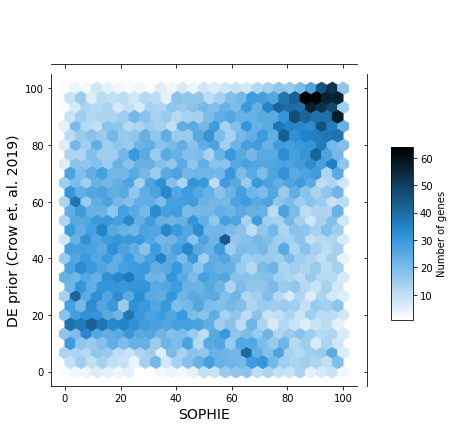

In [19]:
# Get generic genes identified by Crow et. al.
DE_prior_filename = params["reference_gene_filename"]
ref_gene_col = params["reference_gene_name_col"]
ref_rank_col = params["reference_rank_col"]

figure_filename = f"gene_ranking_{col_to_rank_genes}.svg"

corr, shared_ranking = ranking.compare_gene_ranking(
    summary_gene_ranks, DE_prior_filename, ref_gene_col, ref_rank_col, figure_filename
)

In [20]:
# Hypergeometric test:
# Given N number of genes with K common genes in Crow et al.
# SOPHIE identifies n genes as being common
# What is the probability that k of the genes identified by SOPHIE
# are also common in Crow et al.? What is the probability of drawing
# k or more concordant genes?

num_Crow_genes = shared_ranking.shape[0]
num_generic_Crow_genes = shared_ranking.query(f"{ref_rank_col}>=80.0").shape[0]
num_generic_SOPHIE_genes = shared_ranking[
    shared_ranking["Percentile (simulated)"] >= percentile_threshold
].shape[0]
num_concordant_generic_genes = shared_ranking[
    (shared_ranking[ref_rank_col] >= percentile_threshold)
    & (shared_ranking["Percentile (simulated)"] >= percentile_threshold)
].shape[0]

In [21]:
print(num_Crow_genes)
print(num_generic_Crow_genes)
print(num_generic_SOPHIE_genes)
print(num_concordant_generic_genes)

17156
3678
3442
1417


In [22]:
p = ss.hypergeom.sf(
    num_concordant_generic_genes,
    num_Crow_genes,
    num_generic_Crow_genes,
    num_generic_SOPHIE_genes,
)
print(p)

3.097055829554711e-196


The results for SOPHIE vs Crow et. al found a significant over-representation of SOPHIE identified generic genes in Crow et al. generic gene set. Here we found...

In [23]:
# Rank template genes by logFC
# Add to shared_df with noise ranked genes
# signed rank test of gene ranks